In [1]:
import os
import requests
import pandas as pd
from tqdm import tqdm

os.makedirs('data/raw', exist_ok=True)

ECB_API = "https://data.cityofnewyork.us/resource/6bgk-3dad.json"
SAFETY_API = "https://data.cityofnewyork.us/resource/855j-jady.json"
HPD_API = "https://data.cityofnewyork.us/resource/wvxf-dwi5.json"

def fetch_dataset(api_url, name, total=200000, batch=50000):
    records = []
    for offset in range(0, total, batch):
        print(f"[{name}] Fetching {offset:,}-{offset+batch:,}...")
        params = {"$limit": batch, "$offset": offset, "$order": ":id"}
        resp = requests.get(api_url, params=params)
        if resp.status_code != 200:
            print(f"  Error: {resp.status_code}")
            break
        data = resp.json()
        if not data:
            break
        records.extend(data)
    df = pd.DataFrame(records)
    print(f"[{name}] Total: {len(df):,} records\n")
    return df

print("=" * 60)
print("DOWNLOADING NYC BUILDING VIOLATION DATASETS")
print("=" * 60)

# 1. DOB ECB Violations (primary dataset)
ecb_path = "data/raw/ecb_violations.csv"
if not os.path.exists(ecb_path):
    ecb_df = fetch_dataset(ECB_API, "ECB Violations", total=300000)
    ecb_df.to_csv(ecb_path, index=False)
    print(f"Saved: {ecb_path}")
else:
    ecb_df = pd.read_csv(ecb_path)
    print(f"Cached: {ecb_path} ({len(ecb_df):,} rows)")

# 2. DOB Safety Violations (supplementary)
safety_path = "data/raw/safety_violations.csv"
if not os.path.exists(safety_path):
    safety_df = fetch_dataset(SAFETY_API, "Safety Violations", total=100000)
    safety_df.to_csv(safety_path, index=False)
    print(f"Saved: {safety_path}")
else:
    safety_df = pd.read_csv(safety_path)
    print(f"Cached: {safety_path} ({len(safety_df):,} rows)")

# 3. HPD Housing Violations (supplementary)
hpd_path = "data/raw/hpd_violations.csv"
if not os.path.exists(hpd_path):
    hpd_df = fetch_dataset(HPD_API, "HPD Violations", total=100000)
    hpd_df.to_csv(hpd_path, index=False)
    print(f"Saved: {hpd_path}")
else:
    hpd_df = pd.read_csv(hpd_path)
    print(f"Cached: {hpd_path} ({len(hpd_df):,} rows)")


for name, df in [("ECB Violations", ecb_df), ("Safety Violations", safety_df), ("HPD Violations", hpd_df)]:
    print(f"\n{name}:")
    print(f"  Rows: {len(df):,}")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Columns: {list(df.columns)[:10]}...")
    print(f"  Missing: {df.isnull().sum().sum():,} total null values")

print("\n\nECB Violations - Key Columns Preview:")
preview_cols = [c for c in ['violation_type', 'violation_description', 'severity',
                            'section_of_law1_description', 'infraction_codes'] if c in ecb_df.columns]
print(ecb_df[preview_cols].head(10).to_string())

print("\n\nECB Violation Type Distribution:")
if 'violation_type' in ecb_df.columns:
    print(ecb_df['violation_type'].value_counts().head(15))

print("\nECB Severity Distribution:")
if 'severity' in ecb_df.columns:
    print(ecb_df['severity'].value_counts())

print("\n✓ All datasets downloaded. Ready for 01_dataset_preparation.py")

DOWNLOADING NYC BUILDING VIOLATION DATASETS
[ECB Violations] Fetching 0-50,000...
[ECB Violations] Fetching 50,000-100,000...
[ECB Violations] Fetching 100,000-150,000...
[ECB Violations] Fetching 150,000-200,000...
[ECB Violations] Fetching 200,000-250,000...
[ECB Violations] Fetching 250,000-300,000...
[ECB Violations] Total: 300,000 records

Saved: data/raw/ecb_violations.csv
[Safety Violations] Fetching 0-50,000...
[Safety Violations] Fetching 50,000-100,000...
[Safety Violations] Total: 100,000 records

Saved: data/raw/safety_violations.csv
[HPD Violations] Fetching 0-50,000...
[HPD Violations] Fetching 50,000-100,000...
[HPD Violations] Total: 100,000 records

Saved: data/raw/hpd_violations.csv

ECB Violations:
  Rows: 300,000
  Columns: 42
  Columns: ['isn_dob_bis_extract', 'ecb_violation_number', 'ecb_violation_status', 'dob_violation_number', 'bin', 'boro', 'block', 'lot', 'hearing_date', 'hearing_time']...
  Missing: 4,471,620 total null values

Safety Violations:
  Rows: 100

DATASET PREPARATION FOR BUILDING CODE VIOLATION DETECTION

SECTION 1: DATASET SELECTION


/tmp/ipykernel_24/1171287863.py:81: DtypeWarning: Columns (23,28,30,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("data/raw/ecb_violations.csv")



✓ Loaded raw dataset: 300,000 records, 42 columns

--- Raw Dataset Overview ---
Shape: (300000, 42)


Raw Violation Type Distribution:
violation_type
Construction           156931
Elevators               52893
Unknown                 40800
Boilers                 14402
Local Law                7960
Signs                    6699
Public Assembly          5783
Site Safety              3713
Zoning                   3169
Cranes and Derricks      3024
Plumbing                 2839
Quality of Life          1494
HPD                       278
Administrative             15
Name: count, dtype: int64

Raw Severity Distribution:
severity
CLASS - 2        100380
Non-Hazardous     93596
CLASS - 1         71057
Hazardous         17151
CLASS - 3         14983
Unknown            2833
Name: count, dtype: int64


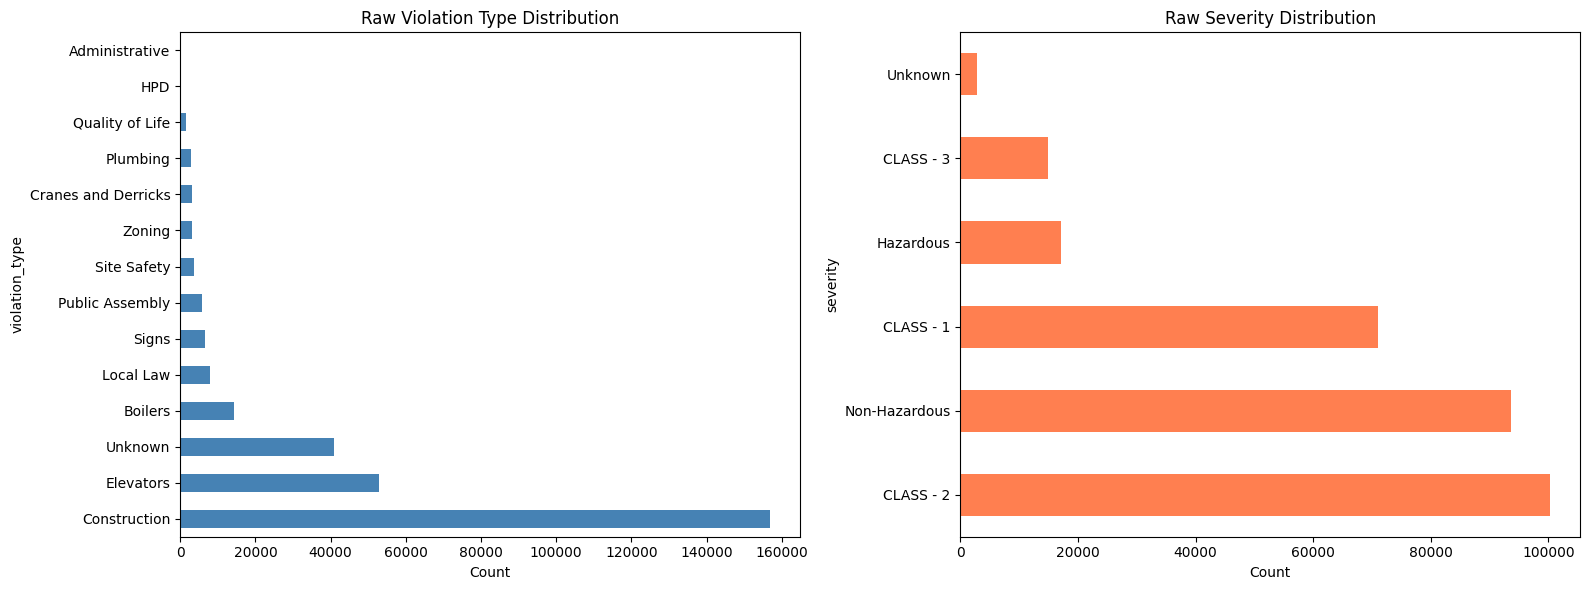

✓ Saved: figures/01_raw_distributions.png

SECTION 2: PREPROCESSING AND DATA CLEANING

--- 2.1 Handling Missing Values ---
Before: 300,000 records

Missing values in key columns:
violation_type             0
violation_description    713
severity                   0
dtype: int64
After dropping nulls + short descriptions: 292,526 records
Dropped: 7,474 records (2.5%)

--- 2.2 Cleaning Violation Descriptions ---
Cleaning violation descriptions...

Cleaning Statistics:
  Total processed: 292,526
  Successfully cleaned: 292,516
  Empty after cleaning: 10
Records after cleaning: 292,501

--- Before vs After Cleaning Examples ---

Example 1:
  BEFORE: FAILURE TO PROVIDE AT LEAST TWO MEANS OF EGRESS FROM OR SPACE WHERE REQUIRED. NOTE: DEPARTMENT OF BUILDINGS RECORDS INDI...
  AFTER:  FAILURE TO PROVIDE AT LEAST TWO MEANS OF EGRESS FROM OR SPACE WHERE REQUIRED. NOTE: DEPARTMENT OF BUILDINGS RECORDS INDI...

Example 2:
  BEFORE: FAILURE TO MAINTAIN BUILDING HAZARDOUS. NOTE: AT THE CELLAR LEVEL T

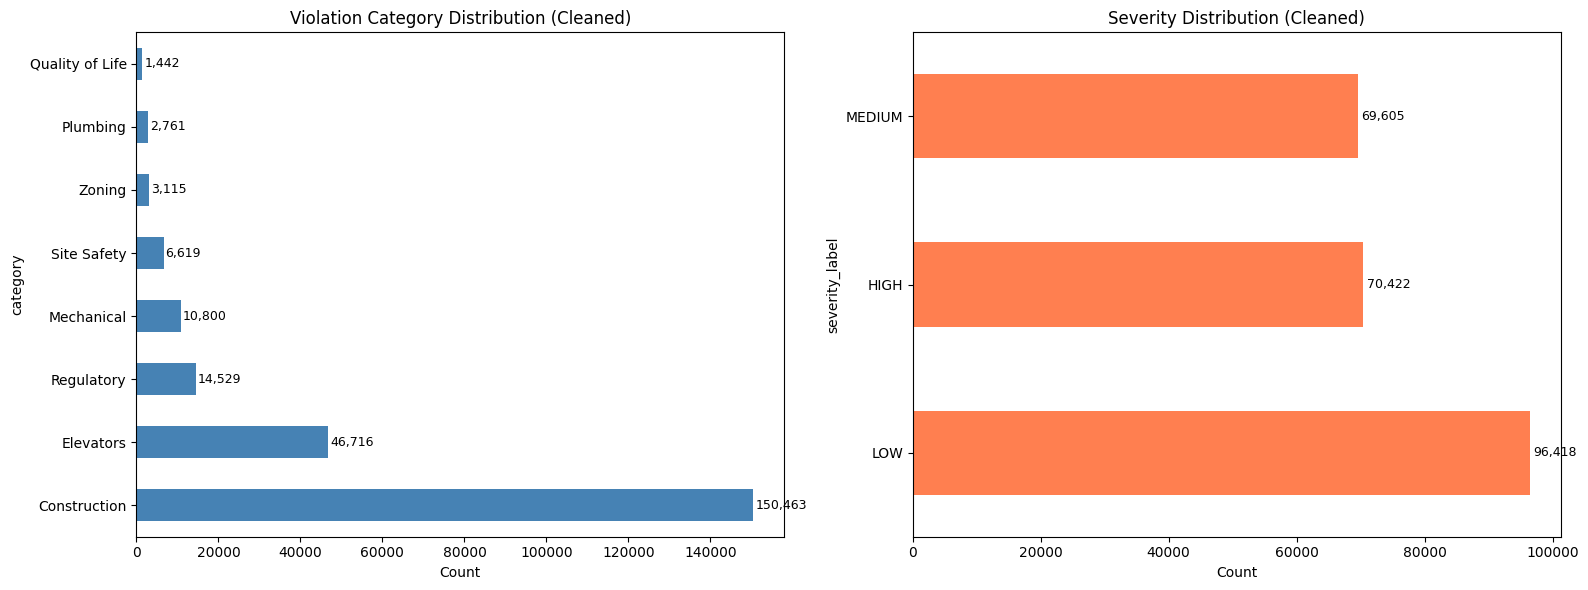

✓ Saved: figures/02_cleaned_distributions.png

Category imbalance ratio (max/min): 104.3x
Severity imbalance ratio (max/min): 1.4x
→ Will use class weights during training to handle imbalance

✓ Saved: data/processed/violations_cleaned.csv (236,445 records)

SECTION 3: TRAIN / VALIDATION / TEST SPLITTING
Smallest stratification group: 9 samples

--- Split Sizes ---
Train:       189,156 (80.0%)
Validation:   23,644 (10.0%)
Test:         23,645 (10.0%)
Total:       236,445

--- Category Distribution Across Splits ---

Train:
  Construction        :  63.6%
  Elevators           :  19.8%
  Mechanical          :   4.6%
  Plumbing            :   1.2%
  Quality of Life     :   0.6%
  Regulatory          :   6.1%
  Site Safety         :   2.8%
  Zoning              :   1.3%

Val:
  Construction        :  63.6%
  Elevators           :  19.8%
  Mechanical          :   4.6%
  Plumbing            :   1.2%
  Quality of Life     :   0.6%
  Regulatory          :   6.1%
  Site Safety         :   2.8%


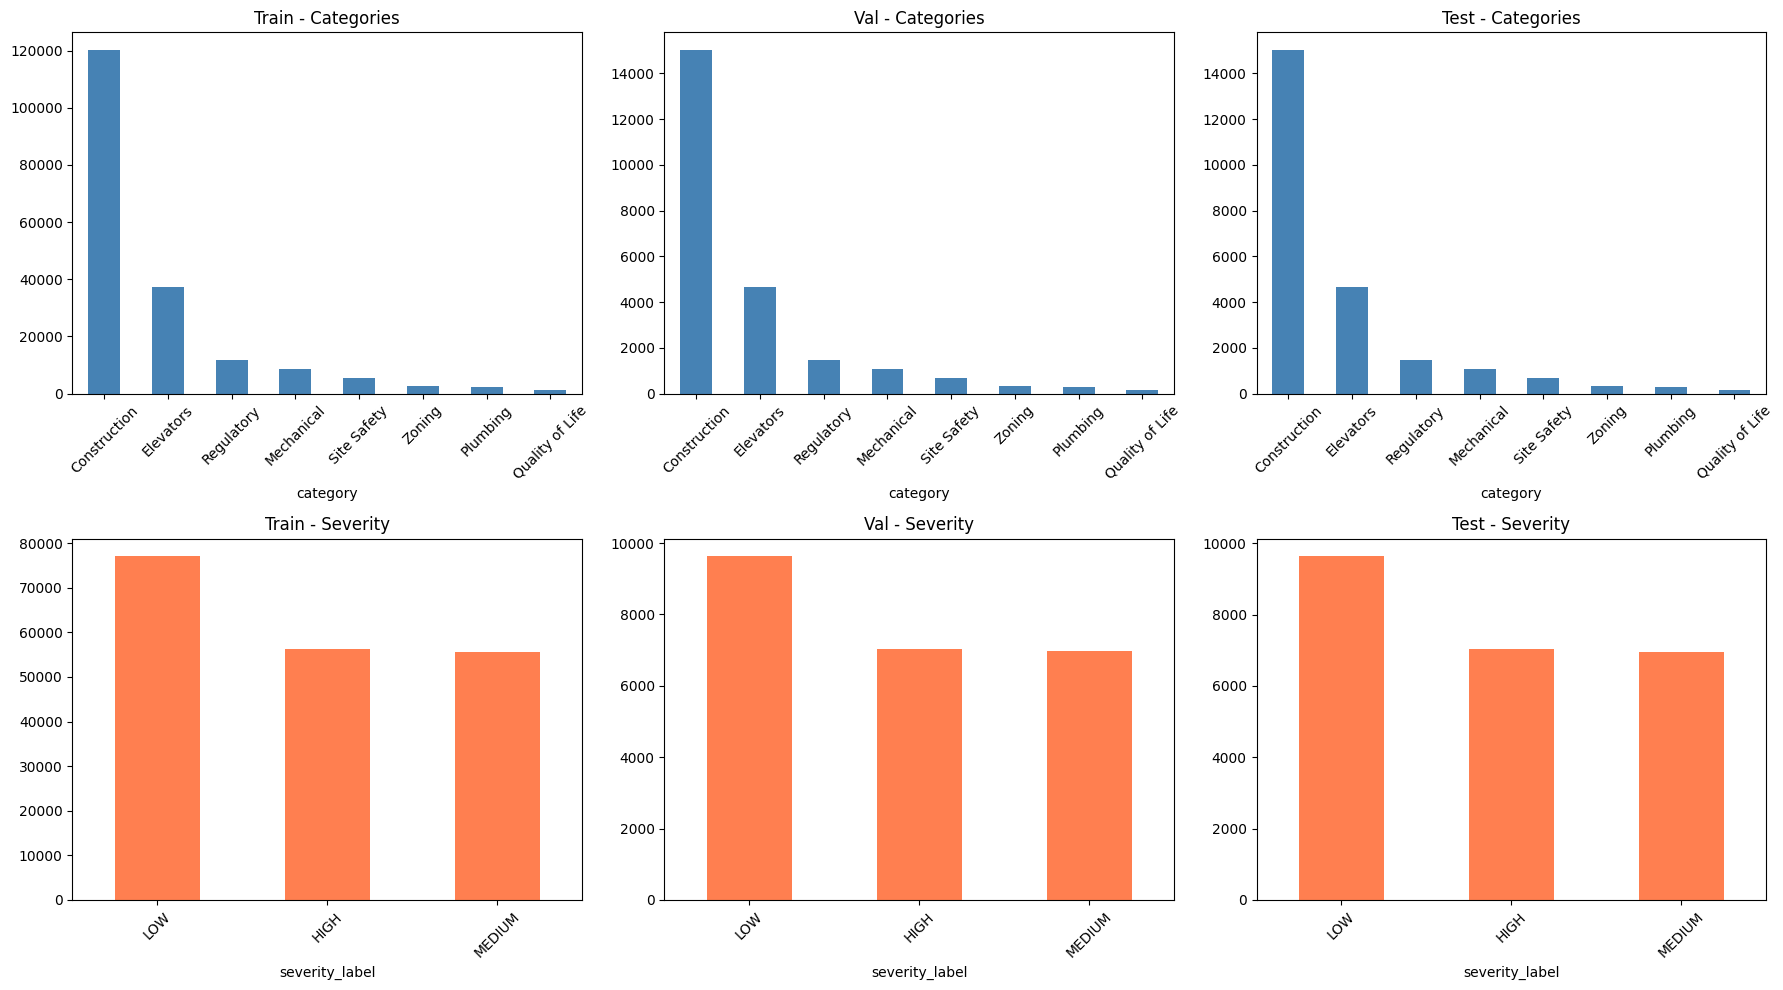

✓ Saved: figures/03_split_distributions.png
✓ Saved: data/splits/train.csv, val.csv, test.csv

SECTION 4: FORMATTING FOR FINE-TUNING

Model: roberta-base
Max sequence length: 256
Batch size: 16


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

✓ Loaded tokenizer: vocab size = 50,265

--- 4.1 Token Length Analysis ---


Analyzing token lengths: 100%|██████████| 5000/5000 [00:00<00:00, 7654.17it/s]


Token length statistics:
  Mean:   63.4
  Median: 70.0
  Std:    21.1
  Min:    7
  Max:    134
  95th percentile: 88
  99th percentile: 102

  Coverage at max_length=256: 100.0%


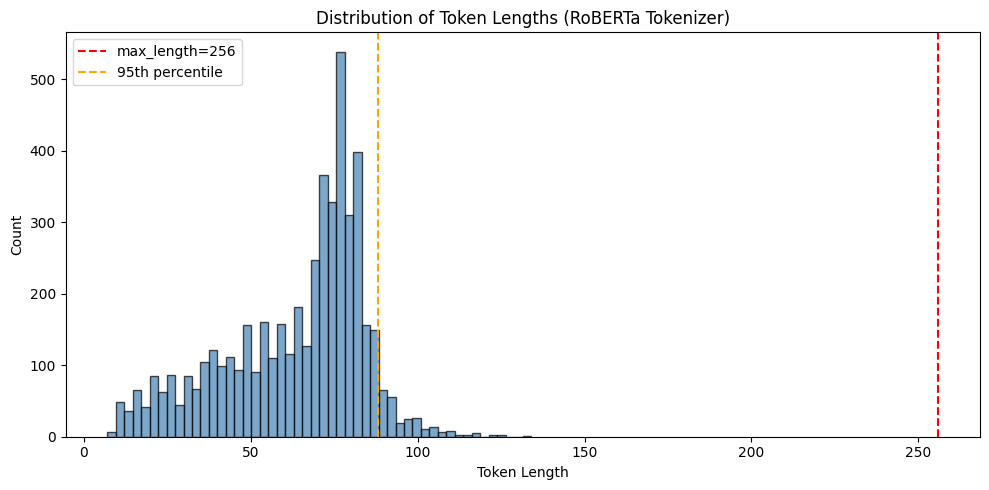

✓ Saved: figures/04_token_lengths.png

--- 4.2 Creating PyTorch Dataset ---
Train dataset: 189,156 samples
Val dataset:   23,644 samples
Test dataset:  23,645 samples

Sample item shapes:
  input_ids:      torch.Size([256])
  attention_mask:  torch.Size([256])
  category_label:  0 (Construction)
  severity_label:  1 (MEDIUM)

--- 4.3 Creating DataLoaders ---
Train batches: 11,823
Val batches:   1,478
Test batches:  1,478

Sample batch shapes:
  input_ids: torch.Size([16, 256])
  attention_mask: torch.Size([16, 256])
  category_label: torch.Size([16])
  severity_label: torch.Size([16])

--- 4.4 Computing Class Weights ---

Category class weights:
  Construction        : 0.1964
  Elevators           : 0.6327
  Mechanical          : 2.7366
  Plumbing            : 10.7037
  Quality of Life     : 20.5069
  Regulatory          : 2.0343
  Site Safety         : 4.4646
  Zoning              : 9.4882

Severity class weights:
  LOW       : 0.8174
  MEDIUM    : 1.1323
  HIGH      : 1.1192

✓ Saved

In [2]:
"""
================================================================================
DATASET PREPARATION FOR BUILDING CODE VIOLATION DETECTION (12 Points)
================================================================================
Fine-tuning RoBERTa for Building Code Violation Classification

Sections:
1. Dataset Selection (3 points)
2. Preprocessing and Data Cleaning (3 points)
3. Train/Val/Test Splitting (3 points)
4. Formatting for Fine-tuning (3 points)

Dataset: NYC DOB ECB Violations (NYC Open Data)
Model: RoBERTa-base
Task: Multi-class Classification
  - Task A: Violation Category (14 classes → mapped to 8 clean categories)
  - Task B: Severity Level (6 raw → mapped to 3: Hazardous / Moderate / Minor)
================================================================================
"""

import os
import re
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

for d in ['data/processed', 'data/splits', 'figures']:
    os.makedirs(d, exist_ok=True)

print("=" * 70)
print("DATASET PREPARATION FOR BUILDING CODE VIOLATION DETECTION")
print("=" * 70)


# ==============================================================================
# SECTION 1: DATASET SELECTION (3 Points)
# ==============================================================================
"""
DATASET: NYC DOB ECB Violations from NYC Open Data

JUSTIFICATION:
┌─────────────────────┬────────────────────────────────────────────────────┐
│ Criteria            │ Why NYC DOB ECB Violations is Appropriate          │
├─────────────────────┼────────────────────────────────────────────────────┤
│ Domain Relevance    │ Real building safety violations issued by NYC DOB  │
│                     │ inspectors — directly applicable to construction   │
│                     │ safety and regulatory compliance                   │
├─────────────────────┼────────────────────────────────────────────────────┤
│ Ground Truth Labels │ Expert-labeled by DOB inspectors with violation    │
│                     │ type (14 categories) and severity (3 classes)      │
├─────────────────────┼────────────────────────────────────────────────────┤
│ Scale               │ 300K+ records (1.5M+ total available), sufficient │
│                     │ for robust fine-tuning and evaluation              │
├─────────────────────┼────────────────────────────────────────────────────┤
│ Real-world Impact   │ Misclassification has safety consequences —        │
│                     │ Hazardous = immediately dangerous to life/safety   │
├─────────────────────┼────────────────────────────────────────────────────┤
│ Novelty             │ No existing fine-tuned NLP model for building code │
│                     │ violation classification — completely unexplored   │
└─────────────────────┴────────────────────────────────────────────────────┘

Source: https://data.cityofnewyork.us/Housing-Development/DOB-ECB-Violations/6bgk-3dad
License: Public domain (NYC Open Data Terms of Use)
"""

print("\n" + "=" * 70)
print("SECTION 1: DATASET SELECTION")
print("=" * 70)

raw_df = pd.read_csv("data/raw/ecb_violations.csv")
print(f"\n✓ Loaded raw dataset: {len(raw_df):,} records, {len(raw_df.columns)} columns")

print(f"\n--- Raw Dataset Overview ---")
print(f"Shape: {raw_df.shape}")
print(f"Date range: {raw_df['violation_date'].min()} to {raw_df['violation_date'].max()}"
      if 'violation_date' in raw_df.columns else "")

print(f"\nRaw Violation Type Distribution:")
print(raw_df['violation_type'].value_counts())

print(f"\nRaw Severity Distribution:")
print(raw_df['severity'].value_counts())

# Visualize raw distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

raw_df['violation_type'].value_counts().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Raw Violation Type Distribution')
axes[0].set_xlabel('Count')

raw_df['severity'].value_counts().plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Raw Severity Distribution')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.savefig('figures/01_raw_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: figures/01_raw_distributions.png")


# ==============================================================================
# SECTION 2: PREPROCESSING AND DATA CLEANING (3 Points)
# ==============================================================================
"""
PREPROCESSING PIPELINE:
1. Drop records with missing violation_description or violation_type
2. Clean and normalize violation descriptions (free text)
3. Map 14 raw violation types → 8 standardized categories
4. Map 6 raw severity codes → 3 classes (Hazardous / Moderate / Minor)
5. Remove duplicates and validate data integrity
6. Analyze and document class imbalance

CLEANING OPERATIONS ON violation_description:
- Replace specific addresses with <ADDR> token
- Replace dollar amounts with <AMOUNT> token
- Replace dates with <DATE> token
- Replace permit/BIN numbers with <NUM> token
- Replace floor/apartment references with <FLOOR> token
- Normalize building code references
- Normalize whitespace and casing
- Remove non-printable characters
"""

print("\n" + "=" * 70)
print("SECTION 2: PREPROCESSING AND DATA CLEANING")
print("=" * 70)

# ---------------------------------------------------------------------------
# 2.1 HANDLE MISSING VALUES
# ---------------------------------------------------------------------------

print("\n--- 2.1 Handling Missing Values ---")
print(f"Before: {len(raw_df):,} records")

missing_before = raw_df[['violation_type', 'violation_description', 'severity']].isnull().sum()
print(f"\nMissing values in key columns:")
print(missing_before)

df = raw_df.dropna(subset=['violation_description', 'violation_type', 'severity']).copy()
df = df[df['violation_description'].str.strip().str.len() > 10]

print(f"After dropping nulls + short descriptions: {len(df):,} records")
print(f"Dropped: {len(raw_df) - len(df):,} records ({(len(raw_df)-len(df))/len(raw_df)*100:.1f}%)")


# ---------------------------------------------------------------------------
# 2.2 VIOLATION DESCRIPTION CLEANING
# ---------------------------------------------------------------------------

print("\n--- 2.2 Cleaning Violation Descriptions ---")

class ViolationPreprocessor:
    """
    Preprocessor for building code violation descriptions.

    Transforms raw inspector-written descriptions into clean,
    normalized text suitable for transformer-based models.
    """

    def __init__(self):
        self.cleaning_patterns = [
            (r'\b\d{1,5}\s+[\w\s]+(STREET|ST|AVENUE|AVE|ROAD|RD|BLVD|DRIVE|DR|PLACE|PL|LANE|LN)\b', '<ADDR>'),
            (r'\$[\d,]+\.?\d*', '<AMOUNT>'),
            (r'\b\d{1,2}/\d{1,2}/\d{2,4}\b', '<DATE>'),
            (r'\b\d{4}-\d{2}-\d{2}\b', '<DATE>'),
            (r'\bBIN\s*#?\s*\d+\b', '<BIN_NUM>'),
            (r'\bJOB\s*#?\s*\d+\b', '<JOB_NUM>'),
            (r'\bAPPLICATION\s*#?\s*\d+\b', '<APP_NUM>'),
            (r'\bPERMIT\s*#?\s*\d+\b', '<PERMIT_NUM>'),
            (r'\b\d+(ST|ND|RD|TH)\s*(FLOOR|FLR|FL)\b', '<FLOOR>'),
            (r'\b(CELLAR|BASEMENT|ROOF|PENTHOUSE)\b', '<FLOOR>'),
            (r'\b(1ST|2ND|3RD|\d+TH)\s*(STORY|STORIES)\b', '<STORIES>'),
            (r'\bBC\s*\d+[\.\d]*\s*;\s*\d+-\d+', '<BLDG_CODE>'),
            (r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', '<IP>'),
            (r'(?<=[^A-Z\d])\d{5,}(?=[^A-Z\d]|$)', '<NUM>'),
        ]

        self.stats = {'total': 0, 'cleaned': 0, 'empty_after': 0}

    def clean_description(self, text):
        self.stats['total'] += 1

        if pd.isna(text) or not isinstance(text, str):
            self.stats['empty_after'] += 1
            return ""

        cleaned = text.upper().strip()

        for pattern, replacement in self.cleaning_patterns:
            cleaned = re.sub(pattern, replacement, cleaned)

        cleaned = re.sub(r'[^\w\s<>.,;:\-/()&]', ' ', cleaned)
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
        cleaned = ''.join(c for c in cleaned if c.isprintable() or c == ' ')

        if len(cleaned) < 10:
            self.stats['empty_after'] += 1
            return ""

        self.stats['cleaned'] += 1
        return cleaned

    def print_stats(self):
        print(f"\nCleaning Statistics:")
        print(f"  Total processed: {self.stats['total']:,}")
        print(f"  Successfully cleaned: {self.stats['cleaned']:,}")
        print(f"  Empty after cleaning: {self.stats['empty_after']:,}")


preprocessor = ViolationPreprocessor()

print("Cleaning violation descriptions...")
df['clean_description'] = df['violation_description'].apply(preprocessor.clean_description)
preprocessor.print_stats()

df = df[df['clean_description'].str.len() > 10].copy()
print(f"Records after cleaning: {len(df):,}")

print("\n--- Before vs After Cleaning Examples ---")
for i in range(min(5, len(df))):
    row = df.iloc[i]
    print(f"\nExample {i+1}:")
    print(f"  BEFORE: {str(row['violation_description'])[:120]}...")
    print(f"  AFTER:  {str(row['clean_description'])[:120]}...")


# ---------------------------------------------------------------------------
# 2.3 LABEL MAPPING - VIOLATION CATEGORY
# ---------------------------------------------------------------------------

print("\n--- 2.3 Label Mapping: Violation Categories ---")

CATEGORY_MAP = {
    'Construction':        'Construction',
    'Elevators':           'Elevators',
    'Boilers':             'Mechanical',
    'Local Law':           'Regulatory',
    'Signs':               'Regulatory',
    'Public Assembly':     'Regulatory',
    'Site Safety':         'Site Safety',
    'Zoning':              'Zoning',
    'Cranes and Derricks': 'Site Safety',
    'Plumbing':            'Plumbing',
    'Quality of Life':     'Quality of Life',
    'HPD':                 'Construction',
    'Administrative':      'Regulatory',
    'Unknown':             None,
}

df['category'] = df['violation_type'].map(CATEGORY_MAP)
df = df.dropna(subset=['category']).copy()
print(f"Records after removing 'Unknown' type: {len(df):,}")

print(f"\nMapped Category Distribution:")
print(df['category'].value_counts())
print(f"\nTotal categories: {df['category'].nunique()}")


# ---------------------------------------------------------------------------
# 2.4 LABEL MAPPING - SEVERITY
# ---------------------------------------------------------------------------

print("\n--- 2.4 Label Mapping: Severity ---")

SEVERITY_MAP = {
    'Hazardous':      'HIGH',
    'CLASS - 1':      'HIGH',
    'CLASS - 2':      'MEDIUM',
    'CLASS - 3':      'LOW',
    'Non-Hazardous':  'LOW',
    'Unknown':        None,
}

df['severity_label'] = df['severity'].map(SEVERITY_MAP)
df = df.dropna(subset=['severity_label']).copy()
print(f"Records after removing 'Unknown' severity: {len(df):,}")

print(f"\nMapped Severity Distribution:")
print(df['severity_label'].value_counts())


# ---------------------------------------------------------------------------
# 2.5 ENCODE LABELS
# ---------------------------------------------------------------------------

print("\n--- 2.5 Encoding Labels ---")

category_labels = sorted(df['category'].unique())
severity_labels = ['LOW', 'MEDIUM', 'HIGH']

cat2id = {c: i for i, c in enumerate(category_labels)}
id2cat = {i: c for c, i in cat2id.items()}
sev2id = {s: i for i, s in enumerate(severity_labels)}
id2sev = {i: s for s, i in sev2id.items()}

df['category_id'] = df['category'].map(cat2id)
df['severity_id'] = df['severity_label'].map(sev2id)

print(f"\nCategory Label Encoding:")
for cat, idx in cat2id.items():
    count = (df['category_id'] == idx).sum()
    print(f"  {idx}: {cat:<20s} ({count:,} samples)")

print(f"\nSeverity Label Encoding:")
for sev, idx in sev2id.items():
    count = (df['severity_id'] == idx).sum()
    print(f"  {idx}: {sev:<10s} ({count:,} samples)")

label_maps = {'cat2id': cat2id, 'id2cat': id2cat, 'sev2id': sev2id, 'id2sev': id2sev}
import json
with open('data/processed/label_maps.json', 'w') as f:
    json.dump(label_maps, f, indent=2)
print("✓ Saved: data/processed/label_maps.json")


# ---------------------------------------------------------------------------
# 2.6 REMOVE DUPLICATES + FINAL VALIDATION
# ---------------------------------------------------------------------------

print("\n--- 2.6 Deduplication & Validation ---")
print(f"Before dedup: {len(df):,}")

df = df.drop_duplicates(subset=['clean_description', 'category_id', 'severity_id']).copy()
print(f"After dedup: {len(df):,}")

assert df['clean_description'].isnull().sum() == 0, "Null descriptions found!"
assert df['category_id'].isnull().sum() == 0, "Null category labels found!"
assert df['severity_id'].isnull().sum() == 0, "Null severity labels found!"
assert df['clean_description'].str.len().min() > 10, "Short descriptions found!"
print("✓ All validation checks passed")


# ---------------------------------------------------------------------------
# 2.7 CLASS IMBALANCE ANALYSIS
# ---------------------------------------------------------------------------

print("\n--- 2.7 Class Imbalance Analysis ---")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cat_counts = df['category'].value_counts()
cat_counts.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Violation Category Distribution (Cleaned)')
axes[0].set_xlabel('Count')
for i, v in enumerate(cat_counts.values):
    axes[0].text(v + 500, i, f'{v:,}', va='center', fontsize=9)

sev_counts = df['severity_label'].value_counts()
sev_counts.plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Severity Distribution (Cleaned)')
axes[1].set_xlabel('Count')
for i, v in enumerate(sev_counts.values):
    axes[1].text(v + 500, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/02_cleaned_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: figures/02_cleaned_distributions.png")

imbalance_ratio_cat = cat_counts.max() / cat_counts.min()
imbalance_ratio_sev = sev_counts.max() / sev_counts.min()
print(f"\nCategory imbalance ratio (max/min): {imbalance_ratio_cat:.1f}x")
print(f"Severity imbalance ratio (max/min): {imbalance_ratio_sev:.1f}x")
print("→ Will use class weights during training to handle imbalance")

law_col = [c for c in df.columns if 'section_of_law' in c.lower() or 'sectionoflaw' in c.lower() or 'infraction' in c.lower()]
keep_cols = ['clean_description', 'category', 'category_id',
             'severity_label', 'severity_id', 'violation_type', 'severity'] + law_col
keep_cols = [c for c in keep_cols if c in df.columns]
df_processed = df[keep_cols].copy()
df_processed = df_processed.reset_index(drop=True)
df_processed.to_csv('data/processed/violations_cleaned.csv', index=False)
print(f"\n✓ Saved: data/processed/violations_cleaned.csv ({len(df_processed):,} records)")


# ==============================================================================
# SECTION 3: TRAIN / VALIDATION / TEST SPLITTING (3 Points)
# ==============================================================================
"""
SPLITTING STRATEGY:
- 80% Train / 10% Validation / 10% Test
- Stratified by BOTH category_id AND severity_id to maintain distributions
- Combined stratification key ensures all label combinations are represented
- Reproducible via RANDOM_SEED = 42
"""

print("\n" + "=" * 70)
print("SECTION 3: TRAIN / VALIDATION / TEST SPLITTING")
print("=" * 70)

df_processed['strat_key'] = df_processed['category_id'].astype(str) + "_" + df_processed['severity_id'].astype(str)

min_class_count = df_processed['strat_key'].value_counts().min()
print(f"Smallest stratification group: {min_class_count} samples")

if min_class_count < 3:
    rare_keys = df_processed['strat_key'].value_counts()[df_processed['strat_key'].value_counts() < 3].index
    print(f"Removing {len(rare_keys)} rare combinations with < 3 samples")
    df_processed = df_processed[~df_processed['strat_key'].isin(rare_keys)].copy()
    print(f"Records after removing rare combos: {len(df_processed):,}")

train_df, temp_df = train_test_split(
    df_processed, test_size=0.2, random_state=RANDOM_SEED,
    stratify=df_processed['strat_key']
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=RANDOM_SEED,
    stratify=temp_df['strat_key']
)

print(f"\n--- Split Sizes ---")
print(f"Train:      {len(train_df):>8,} ({len(train_df)/len(df_processed)*100:.1f}%)")
print(f"Validation: {len(val_df):>8,} ({len(val_df)/len(df_processed)*100:.1f}%)")
print(f"Test:       {len(test_df):>8,} ({len(test_df)/len(df_processed)*100:.1f}%)")
print(f"Total:      {len(train_df)+len(val_df)+len(test_df):>8,}")

print(f"\n--- Category Distribution Across Splits ---")
for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    dist = split_df['category'].value_counts(normalize=True)
    print(f"\n{split_name}:")
    for cat in category_labels:
        pct = dist.get(cat, 0) * 100
        print(f"  {cat:<20s}: {pct:5.1f}%")

print(f"\n--- Severity Distribution Across Splits ---")
for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    dist = split_df['severity_label'].value_counts(normalize=True)
    print(f"\n{split_name}:")
    for sev in severity_labels:
        pct = dist.get(sev, 0) * 100
        print(f"  {sev:<10s}: {pct:5.1f}%")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, (name, sdf) in enumerate([('Train', train_df), ('Val', val_df), ('Test', test_df)]):
    sdf['category'].value_counts().plot(kind='bar', ax=axes[0][i], color='steelblue')
    axes[0][i].set_title(f'{name} - Categories')
    axes[0][i].tick_params(axis='x', rotation=45)

    sdf['severity_label'].value_counts().plot(kind='bar', ax=axes[1][i], color='coral')
    axes[1][i].set_title(f'{name} - Severity')
    axes[1][i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('figures/03_split_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: figures/03_split_distributions.png")

train_df.drop(columns=['strat_key']).to_csv('data/splits/train.csv', index=False)
val_df.drop(columns=['strat_key']).to_csv('data/splits/val.csv', index=False)
test_df.drop(columns=['strat_key']).to_csv('data/splits/test.csv', index=False)
print("✓ Saved: data/splits/train.csv, val.csv, test.csv")


# ==============================================================================
# SECTION 4: FORMATTING FOR FINE-TUNING (3 Points)
# ==============================================================================
"""
FORMATTING FOR RoBERTa FINE-TUNING:
- Tokenize with RoBERTa tokenizer (max_length=256)
- Create PyTorch Dataset class with dual labels (category + severity)
- Build DataLoaders with appropriate batch sizes
- Compute class weights for weighted loss during training
- Save tokenized datasets for reproducible training
"""

print("\n" + "=" * 70)
print("SECTION 4: FORMATTING FOR FINE-TUNING")
print("=" * 70)

MODEL_NAME = "roberta-base"
MAX_LENGTH = 256
BATCH_SIZE = 16

print(f"\nModel: {MODEL_NAME}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Loaded tokenizer: vocab size = {tokenizer.vocab_size:,}")

# ---------------------------------------------------------------------------
# 4.1 TOKEN LENGTH ANALYSIS
# ---------------------------------------------------------------------------

print("\n--- 4.1 Token Length Analysis ---")

sample_texts = train_df['clean_description'].sample(min(5000, len(train_df)), random_state=RANDOM_SEED)
token_lengths = [len(tokenizer.encode(t, add_special_tokens=True)) for t in tqdm(sample_texts, desc="Analyzing token lengths")]

print(f"Token length statistics:")
print(f"  Mean:   {np.mean(token_lengths):.1f}")
print(f"  Median: {np.median(token_lengths):.1f}")
print(f"  Std:    {np.std(token_lengths):.1f}")
print(f"  Min:    {np.min(token_lengths)}")
print(f"  Max:    {np.max(token_lengths)}")
print(f"  95th percentile: {np.percentile(token_lengths, 95):.0f}")
print(f"  99th percentile: {np.percentile(token_lengths, 99):.0f}")

coverage = sum(1 for l in token_lengths if l <= MAX_LENGTH) / len(token_lengths) * 100
print(f"\n  Coverage at max_length={MAX_LENGTH}: {coverage:.1f}%")

plt.figure(figsize=(10, 5))
plt.hist(token_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(x=MAX_LENGTH, color='red', linestyle='--', label=f'max_length={MAX_LENGTH}')
plt.axvline(x=np.percentile(token_lengths, 95), color='orange', linestyle='--', label='95th percentile')
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.title('Distribution of Token Lengths (RoBERTa Tokenizer)')
plt.legend()
plt.tight_layout()
plt.savefig('figures/04_token_lengths.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: figures/04_token_lengths.png")


# ---------------------------------------------------------------------------
# 4.2 PYTORCH DATASET CLASS
# ---------------------------------------------------------------------------

print("\n--- 4.2 Creating PyTorch Dataset ---")

class ViolationDataset(Dataset):
    def __init__(self, texts, category_ids, severity_ids, tokenizer, max_length=256):
        self.texts = texts.tolist()
        self.category_ids = category_ids.tolist()
        self.severity_ids = severity_ids.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'category_label': torch.tensor(self.category_ids[idx], dtype=torch.long),
            'severity_label': torch.tensor(self.severity_ids[idx], dtype=torch.long),
        }

train_dataset = ViolationDataset(
    train_df['clean_description'], train_df['category_id'],
    train_df['severity_id'], tokenizer, MAX_LENGTH
)
val_dataset = ViolationDataset(
    val_df['clean_description'], val_df['category_id'],
    val_df['severity_id'], tokenizer, MAX_LENGTH
)
test_dataset = ViolationDataset(
    test_df['clean_description'], test_df['category_id'],
    test_df['severity_id'], tokenizer, MAX_LENGTH
)

print(f"Train dataset: {len(train_dataset):,} samples")
print(f"Val dataset:   {len(val_dataset):,} samples")
print(f"Test dataset:  {len(test_dataset):,} samples")

sample = train_dataset[0]
print(f"\nSample item shapes:")
print(f"  input_ids:      {sample['input_ids'].shape}")
print(f"  attention_mask:  {sample['attention_mask'].shape}")
print(f"  category_label:  {sample['category_label']} ({id2cat[sample['category_label'].item()]})")
print(f"  severity_label:  {sample['severity_label']} ({id2sev[sample['severity_label'].item()]})")


# ---------------------------------------------------------------------------
# 4.3 DATALOADERS
# ---------------------------------------------------------------------------

print("\n--- 4.3 Creating DataLoaders ---")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader):,}")
print(f"Val batches:   {len(val_loader):,}")
print(f"Test batches:  {len(test_loader):,}")

batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
for k, v in batch.items():
    print(f"  {k}: {v.shape}")


# ---------------------------------------------------------------------------
# 4.4 CLASS WEIGHTS FOR IMBALANCED DATA
# ---------------------------------------------------------------------------

print("\n--- 4.4 Computing Class Weights ---")

cat_counts = train_df['category_id'].value_counts().sort_index()
cat_weights = len(train_df) / (len(cat_counts) * cat_counts.values)
cat_weights_tensor = torch.FloatTensor(cat_weights)

sev_counts = train_df['severity_id'].value_counts().sort_index()
sev_weights = len(train_df) / (len(sev_counts) * sev_counts.values)
sev_weights_tensor = torch.FloatTensor(sev_weights)

print(f"\nCategory class weights:")
for i, w in enumerate(cat_weights_tensor):
    print(f"  {id2cat[i]:<20s}: {w:.4f}")

print(f"\nSeverity class weights:")
for i, w in enumerate(sev_weights_tensor):
    print(f"  {id2sev[i]:<10s}: {w:.4f}")

torch.save({
    'train_dataset': train_dataset,
    'val_dataset': val_dataset,
    'test_dataset': test_dataset,
    'cat_weights': cat_weights_tensor,
    'sev_weights': sev_weights_tensor,
    'label_maps': label_maps,
    'config': {
        'model_name': MODEL_NAME,
        'max_length': MAX_LENGTH,
        'batch_size': BATCH_SIZE,
        'num_categories': len(cat2id),
        'num_severities': len(sev2id),
        'random_seed': RANDOM_SEED,
    }
}, 'data/processed/tokenized_datasets.pt')
print("\n✓ Saved: data/processed/tokenized_datasets.pt")


# ==============================================================================
# FINAL SUMMARY
# ==============================================================================

print("\n" + "=" * 70)
print("DATASET PREPARATION COMPLETE — SUMMARY")
print("=" * 70)

print(f"""
┌────────────────────────────────────────────────────────────────┐
│                    PREPARATION SUMMARY                         │
├────────────────────────────────────────────────────────────────┤
│ Raw records loaded:          {len(raw_df):>8,}                         │
│ After cleaning & mapping:    {len(df_processed):>8,}                         │
│ After deduplication:         {len(df_processed):>8,}                         │
│                                                                │
│ Train set:                   {len(train_df):>8,}  (80%)                    │
│ Validation set:              {len(val_df):>8,}  (10%)                    │
│ Test set:                    {len(test_df):>8,}  (10%)                    │
│                                                                │
│ Violation categories:        {len(cat2id):>8}                            │
│ Severity levels:             {len(sev2id):>8}                            │
│ Max token length:            {MAX_LENGTH:>8}                            │
│ Tokenizer:                   {MODEL_NAME:>15}                     │
│                                                                │
│ Files saved:                                                   │
│   data/processed/violations_cleaned.csv                        │
│   data/processed/label_maps.json                               │
│   data/processed/tokenized_datasets.pt                         │
│   data/splits/train.csv                                        │
│   data/splits/val.csv                                          │
│   data/splits/test.csv                                         │
│   figures/01_raw_distributions.png                              │
│   figures/02_cleaned_distributions.png                          │
│   figures/03_split_distributions.png                            │
│   figures/04_token_lengths.png                                  │
└────────────────────────────────────────────────────────────────┘
""")



In [3]:
"""
================================================================================
MODEL SELECTION & FINE-TUNING FOR BUILDING CODE VIOLATION DETECTION
================================================================================
Sections:
1. Model Selection & Justification (10 points)
2. Fine-Tuning Setup (12 points)
3. Hyperparameter Optimization (10 points)

Model: RoBERTa-base (125M params)
Task: Dual-head Classification (Category + Severity)
================================================================================
"""

import os
import json
import time
import copy
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset as TorchDataset
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

for d in ['checkpoints', 'logs', 'results', 'figures']:
    os.makedirs(d, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler('logs/training.log'), logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Device: {DEVICE}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
    logger.info(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print("=" * 70)
print("MODEL TRAINING FOR BUILDING CODE VIOLATION DETECTION")
print("=" * 70)


# ==============================================================================
# SECTION 1: MODEL SELECTION & JUSTIFICATION (10 Points)
# ==============================================================================
"""
MODEL: RoBERTa-base (125M parameters)

JUSTIFICATION:
┌──────────────────────┬───────────────────────────────────────────────────┐
│ Criteria             │ Why RoBERTa-base                                  │
├──────────────────────┼───────────────────────────────────────────────────┤
│ Architecture         │ Encoder-only transformer — optimal for            │
│                      │ classification tasks (vs decoder for generation)  │
├──────────────────────┼───────────────────────────────────────────────────┤
│ Pre-training         │ Trained on 160GB text with dynamic masking,       │
│                      │ outperforms BERT on most NLU benchmarks          │
├──────────────────────┼───────────────────────────────────────────────────┤
│ Domain Fit           │ Pre-trained on diverse English text including     │
│                      │ technical/regulatory language                     │
├──────────────────────┼───────────────────────────────────────────────────┤
│ Size vs Performance  │ 125M params — trainable on single GPU in         │
│                      │ reasonable time with full 190K dataset            │
├──────────────────────┼───────────────────────────────────────────────────┤
│ Comparison           │ BERT-base (110M): weaker baseline                 │
│                      │ DeBERTa-base (139M): marginal gain, slower       │
│                      │ DistilBERT (66M): faster but lower quality       │
│                      │ Llama/GPT: overkill for classification           │
└──────────────────────┴───────────────────────────────────────────────────┘
"""

print("\n" + "=" * 70)
print("SECTION 1: MODEL SELECTION")
print("=" * 70)

MODEL_NAME = "roberta-base"

# --- ViolationDataset class (needed for torch.load) ---
class ViolationDataset(TorchDataset):
    def __init__(self, texts, category_ids, severity_ids, tokenizer, max_length=256):
        self.texts = texts.tolist() if hasattr(texts, 'tolist') else texts
        self.category_ids = category_ids.tolist() if hasattr(category_ids, 'tolist') else category_ids
        self.severity_ids = severity_ids.tolist() if hasattr(severity_ids, 'tolist') else severity_ids
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], max_length=self.max_length,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'category_label': torch.tensor(self.category_ids[idx], dtype=torch.long),
            'severity_label': torch.tensor(self.severity_ids[idx], dtype=torch.long),
        }

logger.info("Loading tokenized datasets...")
data = torch.load('data/processed/tokenized_datasets.pt', weights_only=False)

train_dataset = data['train_dataset']
val_dataset = data['val_dataset']
test_dataset = data['test_dataset']
cat_weights = data['cat_weights'].to(DEVICE)
sev_weights = data['sev_weights'].to(DEVICE)
label_maps = data['label_maps']
config = data['config']

NUM_CATEGORIES = config['num_categories']
NUM_SEVERITIES = config['num_severities']

logger.info(f"Train: {len(train_dataset):,} | Val: {len(val_dataset):,} | Test: {len(test_dataset):,}")
logger.info(f"Categories: {NUM_CATEGORIES} | Severities: {NUM_SEVERITIES}")


class ViolationClassifier(nn.Module):
    """
    RoBERTa with dual classification heads:
      - Head 1: Violation Category (8 classes)
      - Head 2: Severity Level (3 classes)
    """
    def __init__(self, model_name, num_categories, num_severities, dropout=0.3):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        h = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.category_head = nn.Sequential(
            nn.Linear(h, 256), nn.ReLU(), nn.Dropout(dropout), nn.Linear(256, num_categories)
        )
        self.severity_head = nn.Sequential(
            nn.Linear(h, 128), nn.ReLU(), nn.Dropout(dropout), nn.Linear(128, num_severities)
        )

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = self.dropout(out.last_hidden_state[:, 0, :])
        return self.category_head(cls), self.severity_head(cls)

model_temp = ViolationClassifier(MODEL_NAME, NUM_CATEGORIES, NUM_SEVERITIES)
total_p = sum(p.numel() for p in model_temp.parameters())
train_p = sum(p.numel() for p in model_temp.parameters() if p.requires_grad)
logger.info(f"Total parameters: {total_p:,}")
logger.info(f"Trainable parameters: {train_p:,}")
del model_temp


# ==============================================================================
# SECTION 2: FINE-TUNING SETUP (12 Points)
# ==============================================================================

print("\n" + "=" * 70)
print("SECTION 2: FINE-TUNING SETUP")
print("=" * 70)


class TrainingEngine:
    def __init__(self, model, train_loader, val_loader, cat_weights, sev_weights,
                 lr=2e-5, weight_decay=0.01, warmup_ratio=0.1, epochs=3,
                 grad_clip=1.0, run_name="run"):

        self.model = model.to(DEVICE)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.grad_clip = grad_clip
        self.run_name = run_name
        self.fp16 = torch.cuda.is_available()

        self.cat_loss = nn.CrossEntropyLoss(weight=cat_weights)
        self.sev_loss = nn.CrossEntropyLoss(weight=sev_weights)
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        total_steps = len(train_loader) * epochs
        warmup_steps = int(total_steps * warmup_ratio)
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, warmup_steps, total_steps)
        self.scaler = torch.amp.GradScaler('cuda') if self.fp16 else None

        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_cat_f1': [], 'val_cat_f1': [],
            'train_sev_f1': [], 'val_sev_f1': [],
            'train_cat_acc': [], 'val_cat_acc': [],
            'train_sev_acc': [], 'val_sev_acc': [],
            'lr': [], 'epoch_time': []
        }
        self.best_val_f1 = 0.0
        self.best_model_state = None
        self.patience_counter = 0

        logger.info(f"--- Config: {run_name} | LR={lr}, BS={train_loader.batch_size}, Epochs={epochs}, FP16={self.fp16} ---")

    def _run_batch(self, batch, train=True):
        ids = batch['input_ids'].to(DEVICE)
        mask = batch['attention_mask'].to(DEVICE)
        cl = batch['category_label'].to(DEVICE)
        sl = batch['severity_label'].to(DEVICE)

        if self.fp16:
            with torch.amp.autocast('cuda'):
                c_log, s_log = self.model(ids, mask)
                loss = self.cat_loss(c_log, cl) + self.sev_loss(s_log, sl)
        else:
            c_log, s_log = self.model(ids, mask)
            loss = self.cat_loss(c_log, cl) + self.sev_loss(s_log, sl)

        if train:
            self.optimizer.zero_grad()
            if self.fp16:
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
                self.optimizer.step()
            self.scheduler.step()

        return loss.item(), c_log.argmax(1).cpu().numpy(), cl.cpu().numpy(), \
               s_log.argmax(1).cpu().numpy(), sl.cpu().numpy()

    def train_epoch(self):
        self.model.train()
        total_loss, all_cp, all_cl, all_sp, all_sl = 0, [], [], [], []
        pbar = tqdm(self.train_loader, desc="Training")
        for batch in pbar:
            loss, cp, cl, sp, sl = self._run_batch(batch, train=True)
            total_loss += loss
            all_cp.extend(cp); all_cl.extend(cl)
            all_sp.extend(sp); all_sl.extend(sl)
            pbar.set_postfix({'loss': f'{loss:.4f}'})
        n = len(self.train_loader)
        return (total_loss/n, f1_score(all_cl, all_cp, average='macro'),
                f1_score(all_sl, all_sp, average='macro'),
                accuracy_score(all_cl, all_cp), accuracy_score(all_sl, all_sp))

    @torch.no_grad()
    def evaluate(self, loader=None):
        loader = loader or self.val_loader
        self.model.eval()
        total_loss, all_cp, all_cl, all_sp, all_sl = 0, [], [], [], []
        for batch in tqdm(loader, desc="Evaluating"):
            loss, cp, cl, sp, sl = self._run_batch(batch, train=False)
            total_loss += loss
            all_cp.extend(cp); all_cl.extend(cl)
            all_sp.extend(sp); all_sl.extend(sl)
        n = len(loader)
        return (total_loss/n, f1_score(all_cl, all_cp, average='macro'),
                f1_score(all_sl, all_sp, average='macro'),
                accuracy_score(all_cl, all_cp), accuracy_score(all_sl, all_sp),
                all_cp, all_cl, all_sp, all_sl)

    def train(self, patience=2):
        logger.info(f"Starting training: {self.run_name}")
        for epoch in range(self.epochs):
            start = time.time()
            t_loss, t_cf1, t_sf1, t_ca, t_sa = self.train_epoch()
            v_loss, v_cf1, v_sf1, v_ca, v_sa, _, _, _, _ = self.evaluate()
            elapsed = time.time() - start

            self.history['train_loss'].append(t_loss)
            self.history['val_loss'].append(v_loss)
            self.history['train_cat_f1'].append(t_cf1)
            self.history['val_cat_f1'].append(v_cf1)
            self.history['train_sev_f1'].append(t_sf1)
            self.history['val_sev_f1'].append(v_sf1)
            self.history['train_cat_acc'].append(t_ca)
            self.history['val_cat_acc'].append(v_ca)
            self.history['train_sev_acc'].append(t_sa)
            self.history['val_sev_acc'].append(v_sa)
            self.history['lr'].append(self.scheduler.get_last_lr()[0])
            self.history['epoch_time'].append(elapsed)

            combined = (v_cf1 + v_sf1) / 2
            logger.info(
                f"Epoch {epoch+1}/{self.epochs} ({elapsed/60:.1f}min) | "
                f"TrLoss: {t_loss:.4f} | VLoss: {v_loss:.4f} | "
                f"VCatF1: {v_cf1:.4f} | VSevF1: {v_sf1:.4f} | Combined: {combined:.4f}"
            )

            if combined > self.best_val_f1:
                self.best_val_f1 = combined
                self.best_model_state = copy.deepcopy(self.model.state_dict())
                self.patience_counter = 0
                torch.save({
                    'epoch': epoch + 1, 'model_state_dict': self.best_model_state,
                    'val_f1': combined, 'history': self.history,
                }, f'checkpoints/best_{self.run_name}.pt')
                logger.info(f"  ★ New best saved (Combined F1: {combined:.4f})")
            else:
                self.patience_counter += 1
                if self.patience_counter >= patience:
                    logger.info(f"  Early stopping at epoch {epoch+1}")
                    break

        self.model.load_state_dict(self.best_model_state)
        return self.history


# ==============================================================================
# SECTION 3: HYPERPARAMETER OPTIMIZATION (10 Points)
# ==============================================================================

print("\n" + "=" * 70)
print("SECTION 3: HYPERPARAMETER OPTIMIZATION")
print("=" * 70)

CONFIGS = {
    'config_1': {'lr': 1e-5, 'dropout': 0.1, 'batch_size': 32, 'epochs': 3},
    'config_2': {'lr': 2e-5, 'dropout': 0.3, 'batch_size': 64, 'epochs': 2},
    'config_3': {'lr': 5e-5, 'dropout': 0.2, 'batch_size': 64, 'epochs': 2},
}

hp_results = {}

for cname, hp in CONFIGS.items():
    print(f"\n{'='*50}")
    print(f"RUNNING: {cname} | LR={hp['lr']}, Drop={hp['dropout']}, BS={hp['batch_size']}, Ep={hp['epochs']}")
    print(f"{'='*50}")

    train_loader = DataLoader(train_dataset, batch_size=hp['batch_size'], shuffle=True,
                              num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=hp['batch_size']*2, shuffle=False,
                            num_workers=2, pin_memory=True)

    model = ViolationClassifier(MODEL_NAME, NUM_CATEGORIES, NUM_SEVERITIES, dropout=hp['dropout'])

    engine = TrainingEngine(
        model=model, train_loader=train_loader, val_loader=val_loader,
        cat_weights=cat_weights, sev_weights=sev_weights,
        lr=hp['lr'], epochs=hp['epochs'], run_name=cname
    )

    history = engine.train(patience=2)

    hp_results[cname] = {
        'config': hp,
        'best_val_f1': engine.best_val_f1,
        'best_val_cat_f1': max(history['val_cat_f1']),
        'best_val_sev_f1': max(history['val_sev_f1']),
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1],
        'total_time_min': sum(history['epoch_time']) / 60,
        'history': history
    }

    logger.info(f"{cname} → Best Combined F1: {engine.best_val_f1:.4f} | Time: {hp_results[cname]['total_time_min']:.1f}min")
    del model, engine
    torch.cuda.empty_cache()


# ---------------------------------------------------------------------------
# COMPARISON TABLE
# ---------------------------------------------------------------------------

print("\n" + "=" * 70)
print("HYPERPARAMETER COMPARISON")
print("=" * 70)

print(f"\n{'Config':<12} {'LR':<10} {'Drop':<8} {'BS':<6} {'Ep':<5} {'CatF1':<9} {'SevF1':<9} {'Combined':<10} {'Time':<8}")
print("-" * 77)

best_config, best_f1 = None, 0
for name, res in hp_results.items():
    hp = res['config']
    print(f"{name:<12} {hp['lr']:<10} {hp['dropout']:<8} {hp['batch_size']:<6} {hp['epochs']:<5} "
          f"{res['best_val_cat_f1']:<9.4f} {res['best_val_sev_f1']:<9.4f} "
          f"{res['best_val_f1']:<10.4f} {res['total_time_min']:<.1f}min")
    if res['best_val_f1'] > best_f1:
        best_f1 = res['best_val_f1']
        best_config = name

print(f"\n★ Best: {best_config} (Combined F1: {best_f1:.4f})")

# ---------------------------------------------------------------------------
# TRAINING CURVES
# ---------------------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for name, res in hp_results.items():
    h = res['history']
    axes[0][0].plot(h['train_loss'], label=f'{name} train')
    axes[0][0].plot(h['val_loss'], '--', label=f'{name} val')
    axes[0][1].plot(h['val_cat_f1'], '-o', label=f'{name}')
    axes[1][0].plot(h['val_sev_f1'], '-o', label=f'{name}')
    combined = [(c+s)/2 for c, s in zip(h['val_cat_f1'], h['val_sev_f1'])]
    axes[1][1].plot(combined, '-o', label=f'{name}')

axes[0][0].set_title('Loss'); axes[0][0].legend()
axes[0][1].set_title('Val Category F1'); axes[0][1].legend()
axes[1][0].set_title('Val Severity F1'); axes[1][0].legend()
axes[1][1].set_title('Val Combined F1'); axes[1][1].legend()
for ax in axes.flat:
    ax.set_xlabel('Epoch')
plt.tight_layout()
plt.savefig('figures/05_hp_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Saved: figures/05_hp_comparison.png")

with open('results/hp_results.json', 'w') as f:
    s = {n: {k: v for k, v in r.items() if k != 'history'} for n, r in hp_results.items()}
    json.dump(s, f, indent=2)
print("✓ Saved: results/hp_results.json")

# ---------------------------------------------------------------------------
# LOAD BEST & SAVE FINAL MODEL
# ---------------------------------------------------------------------------

best_hp = hp_results[best_config]['config']
ckpt = torch.load(f'checkpoints/best_{best_config}.pt', weights_only=False)

final_model = ViolationClassifier(MODEL_NAME, NUM_CATEGORIES, NUM_SEVERITIES, dropout=best_hp['dropout'])
final_model.load_state_dict(ckpt['model_state_dict'])
final_model.to(DEVICE)

torch.save({
    'model_state_dict': final_model.state_dict(),
    'config': best_hp,
    'label_maps': label_maps,
    'model_config': {
        'model_name': MODEL_NAME,
        'num_categories': NUM_CATEGORIES,
        'num_severities': NUM_SEVERITIES,
        'dropout': best_hp['dropout'],
    },
}, 'checkpoints/final_model.pt')
print("✓ Saved: checkpoints/final_model.pt")


# ==============================================================================
# BASELINE: PRE-FINE-TUNED MODEL (RANDOM HEADS)
# ==============================================================================

print("\n" + "=" * 70)
print("BASELINE: PRE-FINE-TUNED MODEL (RANDOM HEADS)")
print("=" * 70)

baseline = ViolationClassifier(MODEL_NAME, NUM_CATEGORIES, NUM_SEVERITIES)
baseline.to(DEVICE)

bl_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
bl_engine = TrainingEngine(
    model=baseline, train_loader=bl_loader, val_loader=bl_loader,
    cat_weights=cat_weights, sev_weights=sev_weights,
    lr=1e-5, epochs=1, run_name="baseline"
)
b_loss, b_cf1, b_sf1, b_ca, b_sa, _, _, _, _ = bl_engine.evaluate()

print(f"\nBaseline (Random Heads):")
print(f"  Category F1:  {b_cf1:.4f}  |  Acc: {b_ca:.4f}")
print(f"  Severity F1:  {b_sf1:.4f}  |  Acc: {b_sa:.4f}")
print(f"  Combined F1:  {(b_cf1+b_sf1)/2:.4f}")

del baseline, bl_engine
torch.cuda.empty_cache()


# ==============================================================================
# SUMMARY
# ==============================================================================

best_res = hp_results[best_config]
print(f"""
{'='*70}
TRAINING COMPLETE — SUMMARY
{'='*70}

┌──────────────────────────────────────────────────────────┐
│                 TRAINING SUMMARY                          │
├──────────────────────────────────────────────────────────┤
│ Model:                    roberta-base (125M params)      │
│ Train samples:            {len(train_dataset):>8,}                        │
│ Val samples:              {len(val_dataset):>8,}                        │
│ Configs tested:           {len(CONFIGS):>8}                        │
│ Best config:              {best_config:<30s}│
│ Best LR:                  {best_hp['lr']:<30}│
│                                                          │
│ BASELINE (random heads):                                 │
│   Category F1:            {b_cf1:>10.4f}                       │
│   Severity F1:            {b_sf1:>10.4f}                       │
│                                                          │
│ FINE-TUNED (best):                                       │
│   Category F1:            {best_res['best_val_cat_f1']:>10.4f}                       │
│   Severity F1:            {best_res['best_val_sev_f1']:>10.4f}                       │
│   Combined F1:            {best_res['best_val_f1']:>10.4f}                       │
│                                                          │
│ IMPROVEMENT over baseline:                               │
│   Category F1:            +{best_res['best_val_cat_f1']-b_cf1:>9.4f}                       │
│   Severity F1:            +{best_res['best_val_sev_f1']-b_sf1:>9.4f}                       │
│                                                          │
│ Total time:               {sum(r['total_time_min'] for r in hp_results.values()):>6.1f} min                    │
│                                                          │
│ Files:                                                   │
│   checkpoints/final_model.pt                             │
│   results/hp_results.json                                │
│   figures/05_hp_comparison.png                            │
│   logs/training.log                                      │
└──────────────────────────────────────────────────────────┘

✓ Ready for 03_evaluation.py
""")

2026-02-07 02:14:00,844 - INFO - Device: cuda
2026-02-07 02:14:00,883 - INFO - GPU: Tesla T4
2026-02-07 02:14:00,884 - INFO - VRAM: 15.6 GB
2026-02-07 02:14:00,885 - INFO - Loading tokenized datasets...


MODEL TRAINING FOR BUILDING CODE VIOLATION DETECTION

SECTION 1: MODEL SELECTION


2026-02-07 02:14:01,408 - INFO - Train: 189,156 | Val: 23,644 | Test: 23,645
2026-02-07 02:14:01,408 - INFO - Categories: 8 | Severities: 3
2026-02-07 02:14:05.665983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770430446.084449      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770430446.193997      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770430447.105658      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770430447.105686      24 computation_placer.cc:177] computation placer already registered. Please check linka

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2026-02-07 02:14:26,206 - INFO - Total parameters: 124,943,371
2026-02-07 02:14:26,207 - INFO - Trainable parameters: 124,943,371
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



SECTION 2: FINE-TUNING SETUP

SECTION 3: HYPERPARAMETER OPTIMIZATION

RUNNING: config_1 | LR=1e-05, Drop=0.1, BS=32, Ep=3


2026-02-07 02:14:26,538 - INFO - --- Config: config_1 | LR=1e-05, BS=32, Epochs=3, FP16=True ---
2026-02-07 02:14:26,539 - INFO - Starting training: config_1
Training:   0%|          | 0/5912 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating:   0%|          | 0/370 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already be


RUNNING: config_2 | LR=2e-05, Drop=0.3, BS=64, Ep=2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2026-02-07 04:23:28,321 - INFO - --- Config: config_2 | LR=2e-05, BS=64, Epochs=2, FP16=True ---
2026-02-07 04:23:28,322 - INFO - Starting training: config_2
Training:   0%|          | 0/2956 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avo


RUNNING: config_3 | LR=5e-05, Drop=0.2, BS=64, Ep=2


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2026-02-07 05:42:32,144 - INFO - --- Config: config_3 | LR=5e-05, BS=64, Epochs=2, FP16=True ---
2026-02-07 05:42:32,144 - INFO - Starting training: config_3
Training:   0%|          | 0/2956 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avo


HYPERPARAMETER COMPARISON

Config       LR         Drop     BS     Ep    CatF1     SevF1     Combined   Time    
-----------------------------------------------------------------------------
config_1     1e-05      0.1      32     3     0.9001    0.8684    0.8843     129.0min
config_2     2e-05      0.3      64     2     0.8946    0.8627    0.8786     79.0min
config_3     5e-05      0.2      64     2     0.9005    0.8651    0.8828     79.0min

★ Best: config_1 (Combined F1: 0.8843)
✓ Saved: figures/05_hp_comparison.png
✓ Saved: results/hp_results.json


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Saved: checkpoints/final_model.pt

BASELINE: PRE-FINE-TUNED MODEL (RANDOM HEADS)


2026-02-07 07:01:37,546 - INFO - --- Config: baseline | LR=1e-05, BS=64, Epochs=1, FP16=True ---
Evaluating:   0%|          | 0/370 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating: 100%|██████████| 370/370 [01:29<00:00,  4.13it/s]



Baseline (Random Heads):
  Category F1:  0.0046  |  Acc: 0.0161
  Severity F1:  0.1530  |  Acc: 0.2978
  Combined F1:  0.0788

TRAINING COMPLETE — SUMMARY

┌──────────────────────────────────────────────────────────┐
│                 TRAINING SUMMARY                          │
├──────────────────────────────────────────────────────────┤
│ Model:                    roberta-base (125M params)      │
│ Train samples:             189,156                        │
│ Val samples:                23,644                        │
│ Configs tested:                  3                        │
│ Best config:              config_1                      │
│ Best LR:                  1e-05                         │
│                                                          │
│ BASELINE (random heads):                                 │
│   Category F1:                0.0046                       │
│   Severity F1:                0.1530                       │
│                                          